In [85]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [86]:
data = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
data2 = yf.download("^GSPC", start="2024-01-01", end="2025-01-01")

C:\Users\yahya\AppData\Local\Temp\ipykernel_11408\2141739545.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\yahya\AppData\Local\Temp\ipykernel_11408\2141739545.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data2 = yf.download("^GSPC", start="2024-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [87]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [88]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000
2023-12-28,4783.350098,4793.299805,4780.979980,4786.439941,2698860000
2023-12-29,4769.830078,4788.430176,4751.990234,4782.879883,3126060000


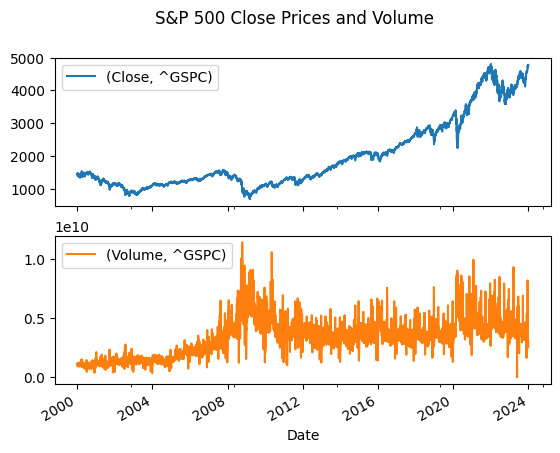

In [89]:
df = data[["Close", "Volume"]].copy()
df2 = data2[["Close", "Volume"]].copy()
df.plot(subplots=True, title="S&P 500 Close Prices and Volume")
plt.show()

In [90]:
df.head()

Price,Close,Volume
Ticker,^GSPC,^GSPC
Date,,
2000-01-03,1455.219971,931800000
2000-01-04,1399.420044,1009000000
2000-01-05,1402.109985,1085500000
2000-01-06,1403.449951,1092300000
2000-01-07,1441.469971,1225200000


In [91]:
df.columns = ['Close', 'Volume']
df2.columns = ['Close', 'Volume']

In [92]:
df[df["Volume"] == 0]
df2[df2["Volume"] == 0]

,Close,Volume
Date,,


In [93]:
print(df[df["Volume"] == 0].count())
df["Volume"] = df["Volume"].replace(0, np.nan)
df["Volume"] = df["Volume"].interpolate(method='linear')
print(df[df["Volume"] == 0].count())

Close     1
Volume    1
dtype: int64
Close     0
Volume    0
dtype: int64


In [94]:
print(df2[df2["Volume"] == 0].count())
# df2["Volume"] = df2["Volume"].replace(0, np.nan)
# df2["Volume"] = df2["Volume"].interpolate(method='linear')
# print(df2[df2["Volume"] == 0].count())

Close     0
Volume    0
dtype: int64


In [95]:
df["Log_Ret"] = np.log(df['Close'] / df['Close'].shift(1)).copy()
df["Volatility"] = (df['Log_Ret'].rolling(window=21).std() * np.sqrt(252)).copy()

log_vol_chg_coef = 1e-9
df["Log_Vol_Chg"] = np.log((df["Volume"] + 1e-9) / (df["Volume"].shift(1) + 1e-9)).copy()

df.head()

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2000-01-03,1455.219971,9.318000e+08,NaN,NaN,NaN
2000-01-04,1399.420044,1.009000e+09,-0.039099,NaN,0.079597
2000-01-05,1402.109985,1.085500e+09,0.001920,NaN,0.073081
2000-01-06,1403.449951,1.092300e+09,0.000955,NaN,0.006245
2000-01-07,1441.469971,1.225200e+09,0.026730,NaN,0.114819


In [96]:
df2["Log_Ret"] = np.log(df2['Close'] / df2['Close'].shift(1)).copy()
df2["Volatility"] = (df2['Log_Ret'].rolling(window=21).std() * np.sqrt(252)).copy()

log_vol_chg_coef = 1e-9
df2["Log_Vol_Chg"] = np.log((df2["Volume"] + 1e-9) / (df2["Volume"].shift(1) + 1e-9)).copy()
df2.head()

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2024-01-02,4742.830078,3743050000,NaN,NaN,NaN
2024-01-03,4704.810059,3950760000,-0.008049,NaN,0.054007
2024-01-04,4688.680176,3715480000,-0.003434,NaN,-0.061400
2024-01-05,4697.240234,3844370000,0.001824,NaN,0.034102
2024-01-08,4763.540039,3742320000,0.014016,NaN,-0.026904


In [97]:
df = df.dropna()
df

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2000-02-02,1409.119995,1.038600e+09,-0.000114,0.257009,0.057056
2000-02-03,1424.969971,1.146500e+09,0.011185,0.220892,0.098840
2000-02-04,1424.369995,1.045100e+09,-0.000421,0.220900,-0.092601
2000-02-07,1424.239990,9.181000e+08,-0.000091,0.220917,-0.129562
2000-02-08,1441.719971,1.047700e+09,0.012198,0.204466,0.132046
...,...,...,...,...,...
2023-12-22,4754.629883,3.046770e+09,0.001659,0.094026,-0.118822
2023-12-26,4774.750000,2.513910e+09,0.004223,0.094171,-0.192243
2023-12-27,4781.580078,2.748450e+09,0.001429,0.093012,0.089198


In [98]:
df2 = df2.dropna()
df2

,Close,Volume,Log_Ret,Volatility,Log_Vol_Chg
Date,,,,,
2024-02-01,4906.189941,4386090000,0.012416,0.114800,-0.068298
2024-02-02,4958.609863,3974350000,0.010628,0.113216,-0.098577
2024-02-05,4942.810059,4023640000,-0.003191,0.113058,0.012326
2024-02-06,4954.229980,4440880000,0.002308,0.113034,0.098666
2024-02-07,4995.060059,4895590000,0.008208,0.107244,0.097482
...,...,...,...,...,...
2024-12-24,6040.040039,1757720000,0.010982,0.137112,-0.715048
2024-12-26,6037.589844,2904530000,-0.000406,0.136852,0.502254
2024-12-27,5970.839844,3159610000,-0.011117,0.140977,0.084177


In [99]:
print(df.isna().sum())
df.interpolate(inplace=True)
print(df.isna().sum())

Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64
Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64


C:\Users\yahya\AppData\Local\Temp\ipykernel_11408\3113013168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(inplace=True)


In [100]:
print(df2.isna().sum())
# df.interpolate(inplace=True)
# print(df.isna().sum())

Close          0
Volume         0
Log_Ret        0
Volatility     0
Log_Vol_Chg    0
dtype: int64


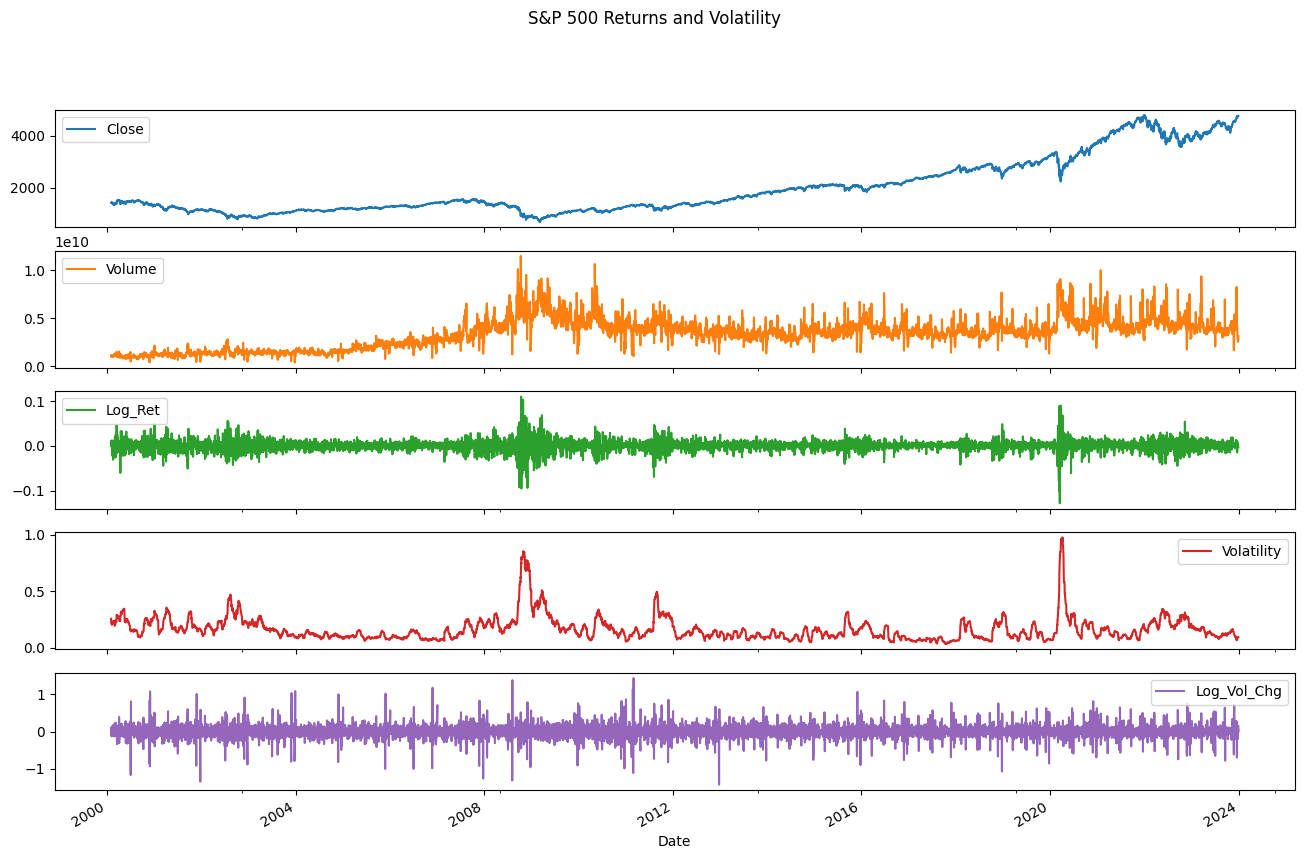

In [101]:
df.plot(subplots=True, title="S&P 500 Returns and Volatility", figsize=(16, 10)) 
plt.show()

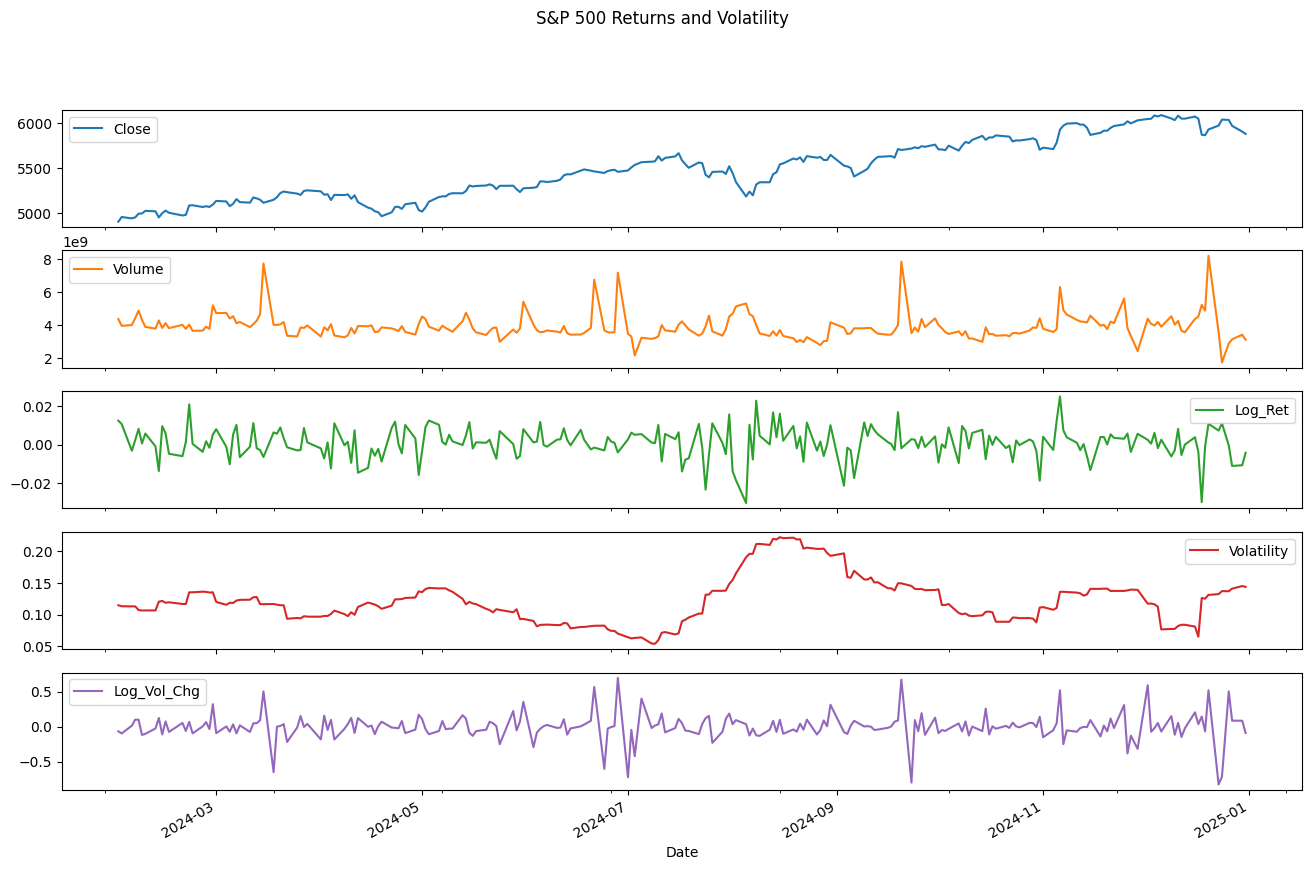

In [102]:
df2.plot(subplots=True, title="S&P 500 Returns and Volatility", figsize=(16, 10)) 
plt.show()

In [103]:
# df[
#     (df.index <= pd.Timestamp("2023-05-30")) & (df.index >= pd.Timestamp("2023-05-21"))
# ]
# # .plot(subplots=True, title="S&P 500 Returns and Volatility (2023)", figsize=(16, 10))

In [104]:
for col in df.columns[:]:
    print(f"{col} - Mean: {df[col].mean()}, Std: {df[col].std()}")
    print("ADF Test:")
    result = adfuller(df[col])
    print(f"\tADF Statistic: {result[0]}")
    print(f"\tp-value: {result[1]}")
    print(f"\tUsed Lag: {result[2]}")
    print(f"\tnobs: {result[3]}")
    # print(f"\tCritical Values:")
    # for key, value in result[4].items():
    #     print(f"\t   {key}: {value}")
    # print("\n")

Close - Mean: 1975.5021639580423, Std: 1062.689392288297
ADF Test:
	ADF Statistic: 1.5606043771122435
	p-value: 0.9977344380716334
	Used Lag: 32
	nobs: 5983
Volume - Mean: 3335258967.75266, Std: 1506055524.6741881
ADF Test:
	ADF Statistic: -3.0581857639046546
	p-value: 0.029806404190163883
	Used Lag: 32
	nobs: 5983
Log_Ret - Mean: 0.0002026648478674413, Std: 0.01236457631899962
ADF Test:
	ADF Statistic: -18.605065777536048
	p-value: 2.0675517862461503e-30
	Used Lag: 17
	nobs: 5998
Volatility - Mean: 0.1657256148491559, Std: 0.10779341192460061
ADF Test:
	ADF Statistic: -6.596890374320472
	p-value: 6.889560145760304e-09
	Used Lag: 29
	nobs: 5986
Log_Vol_Chg - Mean: 0.00019264565244179308, Std: 0.1860497605895532
ADF Test:
	ADF Statistic: -21.83616369283297
	p-value: 0.0
	Used Lag: 31
	nobs: 5984


In [105]:
def create_sequences(data:pd.DataFrame, lookback: int, horizon: int) -> tuple[np.ndarray, np.ndarray]:
    """Create sequences of data for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing features.
        lookback (int): The number of past timesteps to include in each input sequence.
        horizon (int): The number of future timesteps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The input sequences (X) and the corresponding targets (y).
    """
    X, y = [], []

    feature_cols = ['Log_Ret', 'Volatility', 'Log_Vol_Chg']
    data_values = data[feature_cols].values

    for i in range(len(data) - lookback - horizon):
        window = data_values[i : i + lookback]
        future_window = data_values[i + lookback : i + lookback + horizon, 1]

        X.append(window)
        y.append(future_window)

    
    return np.array(X), np.array(y)

X_raw, y_raw = create_sequences(df, lookback=60, horizon=5)

print(f"Created {X_raw.shape[0]} sequences.")
print(f"X shape: {X_raw.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw.shape}  (Samples, Horizon)")

Created 5951 sequences.
X shape: (5951, 60, 3)  (Samples, Timesteps, Features)
y shape: (5951, 5)  (Samples, Horizon)


In [106]:
X_raw2, y_raw2 = create_sequences(df2, lookback=60, horizon=5)
print(f"Created {X_raw2.shape[0]} sequences.")
print(f"X shape: {X_raw2.shape}  (Samples, Timesteps, Features)")
print(f"y shape: {y_raw2.shape}  (Samples, Horizon)")

Created 166 sequences.
X shape: (166, 60, 3)  (Samples, Timesteps, Features)
y shape: (166, 5)  (Samples, Horizon)


In [107]:
# scalers = []
# X_scaled = []
# y_scaled = []

# feature_range = (-1, 1)

# for i in range(X_raw.shape[0]):
#     print(f"Step {i+1}/{X_raw.shape[0]}")

#     # We have 3 features to scale separately
#     scaler = [
#         MinMaxScaler(feature_range=feature_range),
#         MinMaxScaler(feature_range=feature_range),
#         MinMaxScaler(feature_range=feature_range),
#     ]
#     scalers.append(scaler)

#     sol_X = np.zeros_like(X_raw[i])
#     # Log_Ret
#     sol_X[:, 0] = scaler[0].fit_transform(X_raw[i, :, 0].reshape(-1, 1)).reshape(-1)
#     # Volatility
#     sol_X[:, 1] = scaler[1].fit_transform(X_raw[i, :, 1].reshape(-1, 1)).reshape(-1)
#     # Log_Vol_Chg
#     sol_X[:, 2] = scaler[2].fit_transform(X_raw[i, :, 2].reshape(-1, 1)).reshape(-1)

#     X_scaled.append(sol_X)
#     # Target variable (Volatility)
#     y_scaled.append(scaler[1].transform(y_raw[i].reshape(-1, 1)).reshape(-1))


# X_scaled = np.array(X_scaled)
# y_scaled = np.array(y_scaled)

In [126]:
# 1. Flatten the data to fit the scaler on the GLOBAL distribution
# Shape becomes (Total_Samples * 60, 3)
flat_X = X_raw.reshape(-1, 3) 
flat_y = y_raw.reshape(-1, 1) # Target volatility

# 2. Fit scalers on the ENTIRE history, not per window
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform
X_scaled_flat = scaler_X.fit_transform(flat_X)
y_scaled_flat = scaler_y.fit_transform(flat_y)

# 3. Reshape back to (Samples, 60, 3) for the LSTM
X_scaled = X_scaled_flat.reshape(X_raw.shape[0], 60, 3)

# 4. Prepare targets (assuming y was already aligned with X)
# If y is (Samples, 5), you scale it similarly
y_scaled = scaler_y.transform(y_raw.reshape(-1, 1)).reshape(y_raw.shape)
print("Data ready. Global context preserved.")

print(f"X_scaled shape: {X_scaled.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

Data ready. Global context preserved.
X_scaled shape: (5951, 60, 3)
y_scaled shape: (5951, 5)


In [127]:
# 1. Flatten the data to fit the scaler on the GLOBAL distribution
# Shape becomes (Total_Samples * 60, 3)
flat_X2 = X_raw2.reshape(-1, 3) 
flat_y2 = y_raw2.reshape(-1, 1) # Target volatility

# 2. Fit scalers on the ENTIRE history, not per window
scaler_X2 = MinMaxScaler(feature_range=(-1, 1))
scaler_y2 = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform
X_scaled_flat2 = scaler_X2.fit_transform(flat_X2)
y_scaled_flat2 = scaler_y2.fit_transform(flat_y2)

# 3. Reshape back to (Samples, 60, 3) for the LSTM
X_scaled2 = X_scaled_flat2.reshape(X_raw2.shape[0], 60, 3)

# 4. Prepare targets (assuming y was already aligned with X)
# If y is (Samples, 5), you scale it similarly
y_scaled2 = scaler_y2.transform(y_raw2.reshape(-1, 1)).reshape(y_raw2.shape)
print("Data ready. Global context preserved.")

print(f"X_scaled shape: {X_scaled2.shape}")
print(f"y_scaled shape: {y_scaled2.shape}")

Data ready. Global context preserved.
X_scaled shape: (166, 60, 3)
y_scaled shape: (166, 5)


In [128]:
n_sep = int(X_scaled.shape[0] * .8)

X_train, y_train = X_scaled[:n_sep], y_scaled[:n_sep]
X_test, y_test = X_scaled[n_sep:], y_scaled[n_sep:]

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

Training set: X=(4760, 60, 3), y=(4760, 5)
Test set: X=(1191, 60, 3), y=(1191, 5)


In [129]:
n_sep = int(X_scaled2.shape[0] * .8)

X_train2, y_train2 = X_scaled2[:n_sep], y_scaled2[:n_sep]
X_test2, y_test2 = X_scaled2[n_sep:], y_scaled2[n_sep:]

print(f"Training set: X={X_train2.shape}, y={y_train2.shape}")
print(f"Test set: X={X_test2.shape}, y={y_test2.shape}")

Training set: X=(132, 60, 3), y=(132, 5)
Test set: X=(34, 60, 3), y=(34, 5)


In [113]:
# Define shapes based on your data
INPUT_SHAPE = (60, 3)  # (Window Size, Features)
OUTPUT_SIZE = 5  # (Prediction Horizon)

model = Sequential(
    [
        # Input Layer: Matches your (60, 3) shape
        Input(shape=INPUT_SHAPE),
        # LSTM Layer 1: Captures temporal dependencies
        # return_sequences=True is needed if you want to stack another LSTM layer
        LSTM(units=64, return_sequences=True),
        # Prevents overfitting on noisy financial data
        Dropout(0.2),
        # LSTM Layer 2: Compresses the sequence information
        # return_sequences=False because we now want to transition to the dense output
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        # Dense Layer: Interprets the LSTM features
        Dense(16, activation="relu"),
        # Output Layer: Matches your target shape (5 predictions)
        # Activation is 'linear' (default) for regression
        Dense(OUTPUT_SIZE),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,437 (118.89 KB)

 Trainable params: 30,437 (118.89 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Stop training if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.1734 - mae: 0.3121 - val_loss: 0.0234 - val_mae: 0.0848
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0238 - mae: 0.1191 - val_loss: 0.0148 - val_mae: 0.0611
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0161 - mae: 0.0979 - val_loss: 0.0108 - val_mae: 0.0546
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0130 - mae: 0.0887 - val_loss: 0.0085 - val_mae: 0.0484
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0112 - mae: 0.0822 - val_loss: 0.0074 - val_mae: 0.0500
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0093 - mae: 0.0744 - val_loss: 0.0064 - val_mae: 0.0431
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0085 - mae: 0.0713 - val_loss: 0.0056 - val_mae: 0.0416
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0077 - mae: 0.0681 - val_loss: 0.0057 - val_mae: 0.0510
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.006

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


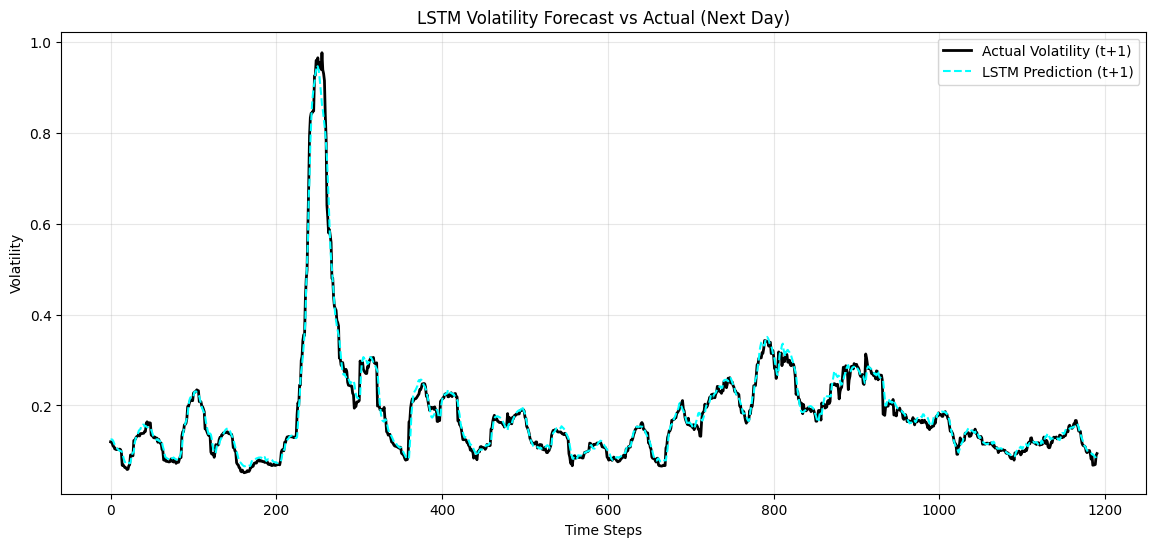

Sample 10 Actual 5-Day Vol:    [0.10341657 0.10403753 0.1029791  0.09707351 0.06847124]
Sample 10 Predicted 5-Day Vol: [0.10146987 0.09761012 0.0951013  0.09247962 0.09153476]


In [134]:
# 1. Generate predictions on the test set
y_pred_scaled = model.predict(X_test)

# 2. Inverse Transform to get "Real" Volatility
# We must reshape to (-1, 1) because the scaler expects 1 feature column
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# 3. Visualization
# Let's plot the prediction for "Day 1" (Next Day Volatility)
plt.figure(figsize=(14, 6))

# Plotting the first 150 days for clarity (plotting all 1000+ points gets messy)
limit = 2000 

plt.plot(y_test_real[:limit, 0], label='Actual Volatility (t+1)', color='black', linewidth=2)
plt.plot(y_pred_real[:limit, 0], label='LSTM Prediction (t+1)', color='cyan', linestyle='--')

plt.title('LSTM Volatility Forecast vs Actual (Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Check the 5-day horizon for a specific sample (e.g., sample #10)
print(f"Sample 10 Actual 5-Day Vol:    {y_test_real[10]}")
print(f"Sample 10 Predicted 5-Day Vol: {y_pred_real[10]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


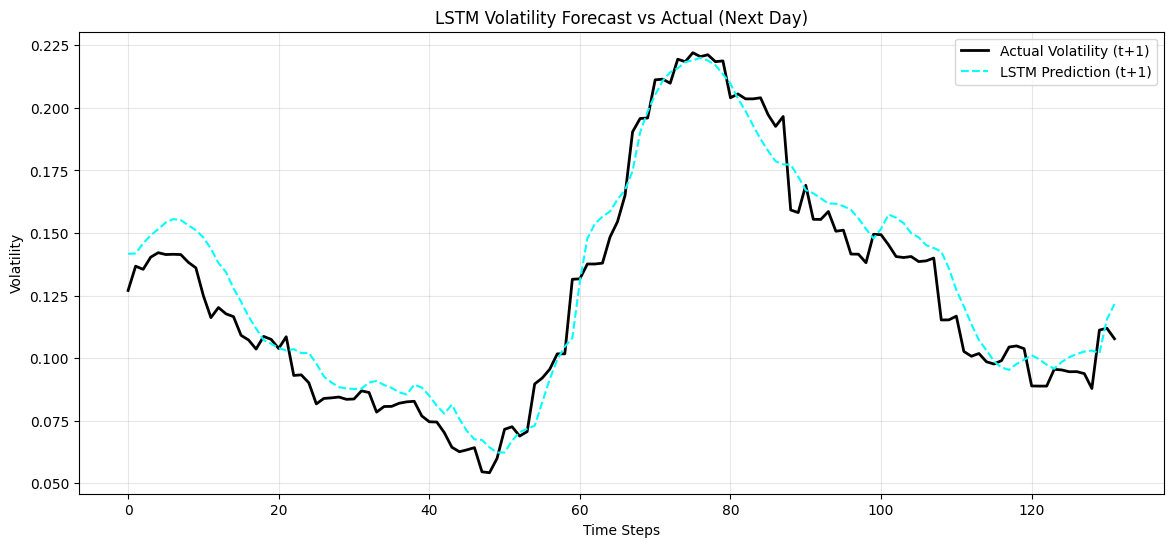

Sample 10 Actual 5-Day Vol:    [0.12489946 0.11616292 0.12019651 0.11768278 0.11654228]
Sample 10 Predicted 5-Day Vol: [0.1481471  0.1506292  0.1458615  0.14387324 0.14466125]


In [135]:

# 1. Generate predictions on the test set
y_pred_scaled2 = model.predict(X_train2)

# 2. Inverse Transform to get "Real" Volatility
# We must reshape to (-1, 1) because the scaler expects 1 feature column
y_pred_real2 = scaler_y2.inverse_transform(y_pred_scaled2.reshape(-1, 1)).reshape(y_pred_scaled2.shape)
y_test_real2 = scaler_y2.inverse_transform(y_train2.reshape(-1, 1)).reshape(y_train2.shape)

# 3. Visualization
# Let's plot the prediction for "Day 1" (Next Day Volatility)
plt.figure(figsize=(14, 6))

# Plotting the first 150 days for clarity (plotting all 1000+ points gets messy)
# limit2 = 150 

plt.plot(y_test_real2[:, 0], label='Actual Volatility (t+1)', color='black', linewidth=2)
plt.plot(y_pred_real2[:, 0], label='LSTM Prediction (t+1)', color='cyan', linestyle='--')

plt.title('LSTM Volatility Forecast vs Actual (Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Check the 5-day horizon for a specific sample (e.g., sample #10)
print(f"Sample 10 Actual 5-Day Vol:    {y_test_real2[10]}")
print(f"Sample 10 Predicted 5-Day Vol: {y_pred_real2[10]}")

### **1. Saving the Model**

The modern standard for Keras (TensorFlow 2.10+) is the **`.keras`** format. It is a single file that stores the architecture, weights, and optimizer state (allowing you to resume training).

```python
# 1. The Modern Keras Format (Recommended)
# Best for storing the model locally or sharing with other Python users
model.save('volatility_lstm.keras')

# 2. The SavedModel Format (Folder)
# Best if you plan to deploy to a server (TensorFlow Serving), mobile (TFLite), or web (TFJS)
# It creates a directory, not a single file.
model.save('saved_models/volatility_lstm_deployment')

```

---

### **2. CRITICAL: Saving the Scalers**

You spent significant effort scaling your data (using `MinMaxScaler` or `RobustScaler`). You **must** save these scaler objects. If you try to predict on raw data later, the model will output garbage.

We use the `joblib` library for this (it's more efficient for numpy arrays than `pickle`).

```python
import joblib

# Assuming you have your scaler objects from the training phase:
# scaler_X = ... (The scaler fitted on input features)
# scaler_y = ... (The scaler fitted on the target/volatility)

# Save them to disk
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("Scalers saved successfully.")

```

---

### **3. How to Load Everything Back**

When you open a new notebook or script to make predictions, you need to load both the model and the scalers.

#### **Scenario A: Standard Model (MSE Loss)**

If you used the standard `mse` loss in your compilation, loading is simple:

```python
from tensorflow.keras.models import load_model
import joblib

# 1. Load the Model
loaded_model = load_model('volatility_lstm.keras')

# 2. Load the Scalers
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

print("Model and scalers loaded. Ready for inference.")

```

In [ ]:
# model.save("../Data/model/lstm_volatility_model.keras")

In [ ]:
# import joblib

In [ ]:
# joblib.dump(scaler_X, "../Data/scaler/scaler_X_pre24.pkl")
# joblib.dump(scaler_X2, "../Data/scaler/scaler_X2_post24.pkl")

# joblib.dump(scaler_y, "../Data/scaler/scaler_y_pre24.pkl")
# joblib.dump(scaler_y2, "../Data/scaler/scaler_y2_post24.pkl")

['../Data/scaler/scaler_y2_post24.pkl']